<a href="https://colab.research.google.com/github/joshuajacobs2020/AirbnbPricePrediction/blob/main/Models_Test_QTM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [ ]:
!git clone https://github.com/joshuajacobs2020/AirbnbPricePrediction
%cd /content/AirbnbPricePrediction

Cloning into 'AirbnbPricePrediction'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 64 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (64/64), 68.02 MiB | 19.64 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/AirbnbPricePrediction


In [ ]:
! unzip "/content/AirbnbPricePrediction/Data/AirbnbCleaned (3).zip"

Archive:  /content/AirbnbPricePrediction/Data/AirbnbCleaned (3).zip
  inflating: AirbnbCleaned.csv       


In [ ]:
df = pd.read_csv("AirbnbCleaned.csv")

<ipython-input-4-bc46c05f669f>:1: DtypeWarning: Columns (13,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("AirbnbCleaned.csv")


In [ ]:
df.columns

Index(['Unnamed: 0', 'index', 'id', 'NAME', 'host id',
       'host_identity_verified', 'host name', 'neighbourhood group',
       'neighbourhood', 'lat', 'long', 'country', 'country code',
       'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 'service fee', 'minimum nights',
       'number of reviews', 'last review', 'reviews per month',
       'review rate number', 'calculated host listings count',
       'availability 365', 'house_rules', 'license', 'totprice', 'Bronx',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island',
       'house_rules_length', 'cancellation_flexible', 'cancellation_moderate',
       'cancellation_strict', 'instant_bookable_dummy', 'Entire home/apt',
       'Hotel room', 'Private room', 'Shared room', 'names_textfeat1',
       'names_textfeat2', 'rules_textfeat1', 'rules_textfeat2'],
      dtype='object')

In [ ]:
# Fixing reviews per month
df.loc[( (df['reviews per month'].isna()) & (df['number of reviews']==0) ),'reviews per month'] = 0
filtered_df = df[df[['number of reviews', 'reviews per month', 'calculated host listings count','Construction year']].isna().any(axis=1)]
df = df.drop(filtered_df.index,axis=0)

In [ ]:
# Define X and Y names
Xcols = ['Bronx',
       'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'number of reviews',
        'reviews per month', 'calculated host listings count', "Construction year",
       'house_rules_length', 'cancellation_flexible', 'cancellation_moderate',
       'cancellation_strict', 'instant_bookable_dummy', 'Entire home/apt',
       'Hotel room', 'Private room', 'Shared room', 'rules_textfeat1', 'rules_textfeat2','names_textfeat1','names_textfeat2']
ycols = ["price"]

# Add Neighborhoods
df_neighbors = df.join(pd.get_dummies(df["neighbourhood"], "n_",dtype=int))

In [ ]:
# Splitting Data
from sklearn.model_selection import train_test_split

# Splitting test and training
split_data = train_test_split(df, random_state = 1, test_size = .2)
training = split_data[0]
test = split_data[1]

# Splitting into x and y
y_train = training[ycols]
X_train = training[Xcols]

y_test = test[ycols]
X_test = test[Xcols]

print("Training obs: {}".format(training.shape[0]))
print("Test obs: {}".format(test.shape[0]))

Training obs: 81280
Test obs: 20321


## Fitting Decision Tree

In [ ]:
import sklearn.model_selection as skm
from sklearn.tree import DecisionTreeRegressor as DTR

# Set models and kfolds
reg_tree = DTR(random_state=0)
kfold = skm.KFold(5, random_state=1, shuffle=True)

# Set parameters
parameters = {'min_samples_leaf':range(2,10),'min_samples_split':range(2,10),'max_depth':range(1,10)}

# Go through grid search
grid = skm.GridSearchCV(reg_tree,
                        parameters,
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
grid.best_params_

{'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [ ]:
# Create decision tree model
from sklearn.tree import DecisionTreeRegressor as DTR
clf = DTR(criterion='squared_error',
          max_depth=4,
          min_samples_split = 2,
          min_samples_leaf = 2,
          random_state=0)

clf.fit(X_train, y_train)

# Evaluate Test MSE
y_hat = clf.predict(X_test)
y_true = np.array(y_test)
np.mean((y_hat - y_true)**2)

110456.5648998994

We can also try cost complexity pruning

In [ ]:
import sklearn.model_selection as skm
from sklearn.model_selection import ShuffleSplit
import random

# Define decision tree model
random.seed(123)
clf = DTR(random_state=123)
clf.fit(X_train, y_train)
split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)

# Do cross validaiton to get optimal cost complexity pruning value
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': random.sample(list(ccp_path.ccp_alphas),100)},
                        refit=True,
                        cv=split,
                        scoring='neg_mean_squared_error')

# Store best model
grid.fit(X_train, y_train)
grid.best_score_
best_ = grid.best_estimator_

In [ ]:
# Getting training MSE
y_pred = best_.predict(X_train)
print("Training MSE:", np.mean((y_pred - np.array(y_train))**2))

# Getting test MSE
y_pred = best_.predict(X_test)
print("Test MSE:", np.mean((y_pred - np.array(y_test))**2))

NameError: name 'best_' is not defined

In [ ]:
# This is performing pretty bad. Compare this to the MSE of just using the average price as a prediction
np.mean((np.mean(df["price"]) - df["price"])**2)

110011.21032892229

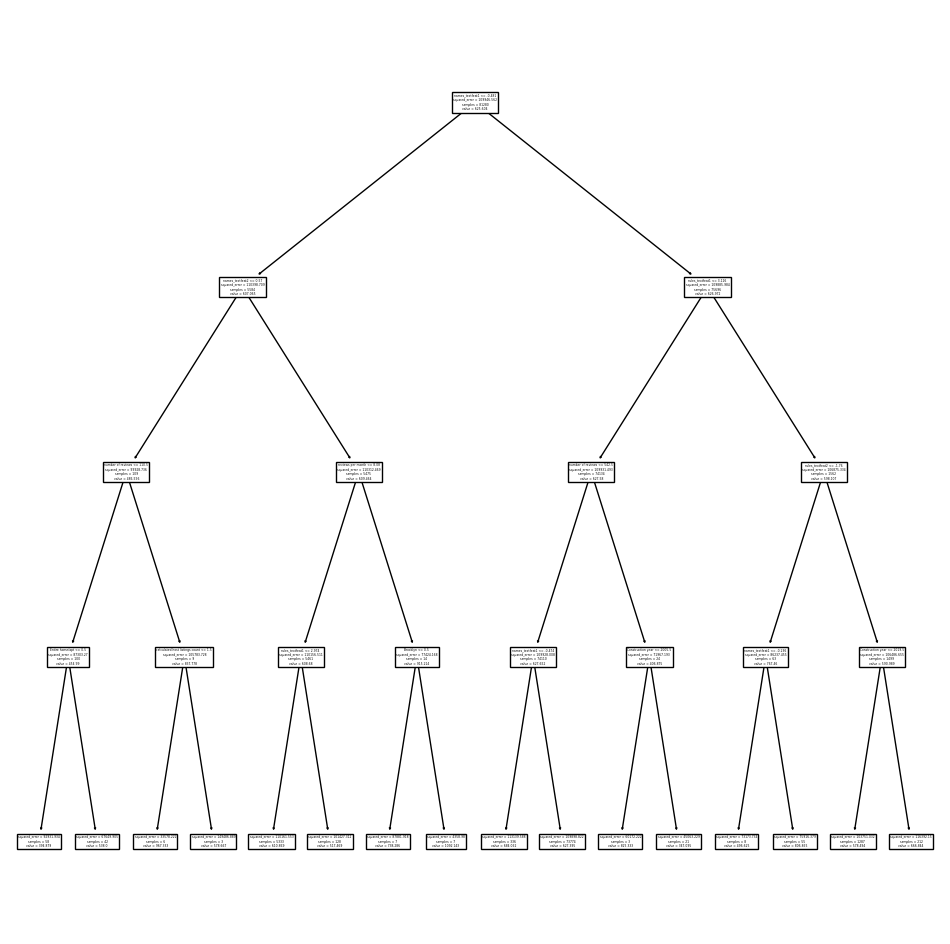

In [ ]:
# Visualize the tree
from matplotlib.pyplot import subplots
from sklearn.tree import plot_tree
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=Xcols,
          ax=ax);

# Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF
rf = RF(n_estimators=100,
        min_samples_leaf=20,
        min_samples_split=20,
        random_state=0)
rf.fit(X_train, y_train.values.ravel())

# Evaluate Test MSE
y_hat = rf.predict(X_test)
y_true = np.array(y_test)
np.mean((y_hat - y_true)**2)

112224.59355390319

In [ ]:
feature_imp = pd.DataFrame({'importance':rf.feature_importances_}, index=Xcols)
feature_imp.sort_values(by='importance', ascending=False)

,importance
names_textfeat2,0.195017
names_textfeat1,0.188415
reviews per month,0.161427
number of reviews,0.114327
rules_textfeat2,0.070659
rules_textfeat1,0.066759
house_rules_length,0.060711
calculated host listings count,0.041967
instant_bookable_dummy,0.019370
Brooklyn,0.015313


Random Forest is also doing pretty bad. Let's try tuning it more.

## Boosting

Decision trees aren't doing well. Neither is random forest. What about boosting? Let's start by finding the best parameters.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import ShuffleSplit

# Initialize model with train/test split validation
boost = GBR(random_state=123,learning_rate=.01)
split = ShuffleSplit(n_splits=5, test_size=0.2, random_state=123)

# Set parameters
parameters = {'max_depth':range(1,5),
              'n_estimators':range(1,1001),
              'learning_rate':np.arange(0.001, 0.1001,0.001)}

# Go through random search to coarsen the grid search
random = skm.RandomizedSearchCV(boost,
                                parameters,
                                refit=True,
                                n_iter=10,
                                random_state=123,
                                cv=split,
                                scoring='neg_mean_squared_error')

random.fit(X_train, y_train.values.ravel())
print(random.best_score_*-1, random.best_params_)

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
boost = GBR(n_estimators=100,
            learning_rate=0.01,
            max_depth=2,
            min_samples_leaf=7,
            min_samples_split=2,
            random_state=0)
boost.fit(X_train, y_train)

# Evaluate Test MSE
y_hat = boost.predict(X_test)
y_true = np.array(y_test)
np.mean((y_hat - y_true)**2)

In [ ]:
feature_imp = pd.DataFrame({'importance':boost.feature_importances_}, index=Xcols)
feature_imp.sort_values(by='importance', ascending=False)

This is also doing poorly. Its slightly better than the decision tree regressor. Potentially, we could improve this by better selecting tuning parameters.

For random forest, we can try using OOB error to select better tuning parameters. Or we can cross validate with GBR.

## Testing Dimension Reduction

### Testing PLS

In [ ]:
# Do kfolds
import sklearn.model_selection as skm
from sklearn.cross_decomposition import PLSRegression
kfold = skm.KFold(5, random_state=1, shuffle=True)

# Set parameters
parameters = {'n_components':range(1,10)}
pls = PLSRegression(scale=True)

# Go through grid search
grid = skm.GridSearchCV(pls,
                        parameters,
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')

grid.fit(X_train,y_train)
grid.best_params_

KeyboardInterrupt: 

In [ ]:
from sklearn.cross_decomposition import PLSRegression

# fit PLS using 8 components with standardization
pls = PLSRegression(n_components=8,scale=True)
pls.fit(X_train, y_train)

# Getting training MSE
train_pred = pls.predict(X_train)
test_error = np.mean((y_train - train_pred)**2)
print("Training MSE:", test_error)

# Getting test MSE
test_pred = pls.predict(X_test)
test_error = ((np.array(y_test) - test_pred)**2).mean()
print("Test MSE:", test_error)

Training MSE: 110057.28603338252
Test MSE: 109688.84281349731


### Doing PCR

In [ ]:
# PCA followed by linear regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Define pipeline steps: scale, then run PCA, then do linear regression
pca = PCA(n_components=3)
linreg = LinearRegression()
scaler = StandardScaler(with_mean=True, with_std=True)

# Define pipeline
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
pipe.fit(X_train, y_train)

# Get training MSE
train_yhats = pipe.predict(X_train)
train_MSE = ((np.array(y_train) - np.array(train_yhats)) ** 2).mean()
print("Train MSE: ", train_MSE)

# Get test MSE
test_yhats = pipe.predict(X_test)
test_MSE = ((np.array(y_test) - np.array(test_yhats)) ** 2).mean()
print("Test MSE: ", test_MSE)

Train MSE:  110086.69412446361
Test MSE:  109670.82819241613


## Doing Regularization

## Ridge

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setting random_state, since I use LOOCV this shouldn't be too important
np.random.RandomState(123)

# Setting tuning parameters to check
lambdas = 10**np.linspace(4, -6, 101)

# Cross Validating for optimal lambda
ridgecv = ElasticNetCV(alphas=lambdas, cv = None, l1_ratio=0.) # perform LOOCV
scaler = StandardScaler(with_mean=True, with_std=True)

# Define pipeline steps to scale and then do cross-validation
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridgecv', ridgecv)]);
pipeCV.fit(X_train, y_train);

# Get optimal lambda
tuned_ridge = pipeCV.named_steps['ridgecv']
tunedlambda_ridge  = tuned_ridge.alpha_

In [ ]:
print("Optimal Lambda:", tunedlambda_ridge)

Optimal Lambda: 2.5118864315095797


In [ ]:
from sklearn.linear_model import Ridge

# Run ridge regression with optimal lambda values
ridge = Ridge(alpha=0)
pipeRidge = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipeRidge.fit(X_train, y_train)

# Getting training MSE
y_pred = pipeRidge.predict(X_train)
print("Training MSE:", np.mean((y_pred - np.array(y_train))**2))

# Getting test MSE
y_pred = pipeRidge.predict(X_test)
print("Test MSE:", np.mean((y_pred - np.array(y_test))**2))

Training MSE: 109917.48546527847
Test MSE: 110238.03300963635


## Lasso

In [ ]:
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setting random_state, since I use LOOCV this shouldn't be too important
np.random.RandomState(123)

# Setting tuning parameters to check
lambdas = 10**np.linspace(4, -6, 101)

# Cross Validating for optimal lambda
ridgecv = ElasticNetCV(alphas=lambdas, cv = None, l1_ratio=1.) # perform LOOCV
scaler = StandardScaler(with_mean=True, with_std=True)

# Define pipeline steps to scale and then do cross-validation
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridgecv', ridgecv)]);
pipeCV.fit(X_train, y_train);

# Get optimal lambda
tuned_ridge = pipeCV.named_steps['ridgecv']
tunedlambda_lasso  = tuned_ridge.alpha_

In [ ]:
print("Optimal Lambda:", tunedlambda_lasso)

Optimal Lambda: 1.5848931924611125


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
scaler = StandardScaler(with_mean=True, with_std=True)

# Run ridge regression with optimal lambda values
lasso = Lasso(alpha=1.58489)
pipelasso = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)])
pipelasso.fit(X_train, y_train)

## Running this code is crashing colab for some reason ##

# Getting training MSE
#y_pred = pipelasso.predict(X_train)
#print("Training MSE:", np.mean((y_pred - np.array(y_train))**2))

# Getting test MSE
#y_pred = pipelasso.predict(X_test)
#print("Test MSE:", np.mean((y_pred - np.array(y_test))**2))

Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=1.58489))])

In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression

# Define pipeline steps: scale, then run PCA, then do linear regression
linreg = LinearRegression()

# Define pipeline
linreg.fit(X_train, y_train)

# Get training MSE
train_yhats = linreg.predict(X_train)
train_MSE = ((np.array(y_train) - np.array(train_yhats)) ** 2).mean()
print("Train MSE: ", train_MSE)

# Get test MSE
test_yhats = linreg.predict(X_test)
test_MSE = ((np.array(y_test) - np.array(test_yhats)) ** 2).mean()
print("Test MSE: ", test_MSE)

Train MSE:  109908.62326983173
Test MSE:  110257.40567625756
